Preprocessing the Word
----------------------------

### Tyler Shoemaker

### UC Davis

In [1]:
# Handle all the imports at once
import random
import re
import json
import subprocess
import warnings
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from stemmers import lovins
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

warnings.simplefilter('ignore', RuntimeWarning)
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [2]:
# A wrapper around the Gage data compressor.
# Code here: https://github.com/Algorithms-in-cpp/CUJ-1990-2000/tree/1fd9fc2ed887229c0c9774e408e2c0f17e010910/SOURCE/1997/SEP97
class GageBP():
    
    def __init__(self, compressor="GAGE/compressor", decompressor="GAGE/decompressor"):
        # Initialize by populating paths to the compressor and decompressor
        self.compressor = compressor
        self.decompressor = decompressor
        
    def encode(self, s, infile="data/to_encode.txt", outfile="data/encoded.txt", encoding='latin1'):
        # To compress, write the string to a file
        with open(infile, 'w', encoding=encoding) as to_encode:
            to_encode.write(s)
        
        # Run the byte-pair compression on that file and save the encoded text to a new one, 
        # then open the latter
        result = subprocess.run([self.compressor, infile, outfile], stdout=subprocess.PIPE)
        with open(outfile, 'rb') as encoded:
            encoded = encoded.read()
            
        # Get the stdout message (if one exists) and return alongside the encoded string
        message = result.stdout.decode('ascii')
        return message, encoded
    
    def decode(self, infile="data/encoded.txt", outfile="data/decompressed.txt"):
        # To decompress, run the byte-pair decompressor over the file and load in the file contents
        result = subprocess.run([self.decompressor, infile, outfile])
        with open(outfile, 'r') as decompressed:
            return decompressed.read()
        
gage = GageBP()

Intent, sign machines, and tokens
----------------------------------------

Text generated by an LM [language model] is not grounded in **communicative intent**, any model of the world, or any model of the reader's state of mind. . . . The problem is, if one side of the communication does not have meaning, then the comprehension of the implicit meaning is an illusion arising from our singular human understanding of language (Bender and Gebru et al. 2021)

Language is comparable to a machine that always works, no matter what damage may be inflicted upon it (Saussure 1910-11)

Sign machines operate 'prior' and 'next' to signification, producing a 'sense without meaning,' an 'operational sense'. . . . [Their] asignifying semiotics act on things (Lazzarato 2014)

Material language. . . . operates in the manner of a telephone exchange system or a cybernetic machine that runs automatically regardless of what happens to pass down its wires (Liu 2010)

In [3]:
with open("data/bert_vocab.txt", 'r') as f:
    bert_vocab = f.read().split('\n')

weights = [2.2 if '#' in i else 1 for i in bert_vocab]
  
print("BERT vocabulary samples\n-----------------------")
for token in random.choices(bert_vocab, weights = weights, k = 10):
    print(token)

BERT vocabulary samples
-----------------------
postgraduate
1611
tasted
##brush
directions
shillings
ipad
明
reprise
completed


In [4]:
subword_example = ['program', '##matic', 'token', '##ization']

print("'programmatic tokenization'\n---------------------------")
for token in subword_example:
    print(token)

'programmatic tokenization'
---------------------------
program
##matic
token
##ization


### Approaching a language with n-grams (Shannon 1948)

**Bigrams**

ON IE ANTSOUTINYS ARE T INCTORE ST BE S DEAMY ACHIN D ILONASIVE TUCOOWE AT TEASONARE FUSO TIZIN ANDY TOBE SEACE CTISBE.

**Trigrams**

IN NO IST LAT WHEY CRATICT FROURE BIRS GROCID PONDENOME OF DEMONS TURES OF THE REPTAGIN IS REGOACTIONA OF CRE.

<div>
    <br>
    <center>
        <img src="data/img/ngrams_pied_piper.png" width="60%" />
    </center>
    <p style="text-align:right;">Byte Magazine 1988</p>
    <br>
</div>

<div>
    <br>
    <center>
        <img src="data/img/subword_paper_head.png" width="80%" />
    </center>
</div>

<div>
    <br>
    <center>
        <img src="data/img/wordpiece_paper_head.png" width="80%" />
    </center>
</div>

<div>
    <br>
    <center>
        <img src="data/img/subword_head_view.png" width="60%" />
    </center>
    <p style="text-align:right;">Visualization library: Vig 2019</p>
    <br>
</div>

Subword tokenization: the algorithm
-------------------------------------------

In [5]:
def pair_stats(vocab):
    # Create an empty dictionary to store count data
    pairs = defaultdict(int)
    
    # For every vocabulary word and its associated count:
    for word, freq in vocab.items():
        
        # Split the word into a list of substrings along the whitespace
        # character ("word" => ["w", "o", "r", "d"])
        symbols = word.split()
        
        # Then, for each substring:
        for i in range(len(symbols) - 1):
            
            # Pair it with the next one in the sequence ("w" => "w","o")
            p = symbols[i], symbols[i + 1]
            
            # And either add that pair to the dictionary and give it the word count, 
            # or, if the pair is already in the dictionary, add the new count
            pairs[p] += freq
            
    # Return the count data
    return pairs

In [6]:
vocab = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3
}

pairs = pair_stats(vocab)

print("Vocabulary\n----------")
for word, count in vocab.items():
    print(f"{word}: {count}")
    
print(
    "\nExample pair counts\n-------------------",
    f"\nl & o: {pairs[('l', 'o')]}", f"\ns & t: {pairs[('s', 't')]}"
)

Vocabulary
----------
l o w </w>: 5
l o w e r </w>: 2
n e w e s t </w>: 6
w i d e s t </w>: 3

Example pair counts
------------------- 
l & o: 7 
s & t: 9


In [7]:
def merge_vocab(pair, unmerged_vocab):
    # Create an empty dictionary
    merged_vocab = {}
    
    # Join the pair of substrings into a single string with a whitespace character in the middle
    bigram = re.escape(' '.join(pair))
    
    # Compile the joined string into a searchable regular expression
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    
    # For every vocabulary word:
    for word in unmerged_vocab:
        
        # Search for the pair. If found, remove the whitespace between the two parts 
        # of the pair ("e", "s": "n e w e s t" => "n e w es t")
        w_out = p.sub(''.join(pair), word)
        
        # Then update the vocabulary with this new version of the word
        merged_vocab[w_out] = unmerged_vocab[word]
        
    # Return the merged vocabulary
    return merged_vocab

In [8]:
old_vocab = vocab.copy()
best_of = []

# For each of 5 runs:
for i in range(5):
    
    # Get the stats for each pair in the vocabulary
    pairs = pair_stats(vocab)
    
    # Find the most frequent pair and append the result to a list
    best = max(pairs, key = pairs.get)
    best_of.append(best)
    
    # And use this pair to merge together characters in the vocabulary
    vocab = merge_vocab(best, vocab)

In [9]:
print("Pair | With\n-----------")
for pair in best_of:
    print(f"{pair[0]:>4}   {pair[1]}")

print("\nFinal merges\n------------")
for old, new in zip(old_vocab, vocab):
    print(
        f"{old:<16}",
        f"=> {new}"
    )

Pair | With
-----------
   e   s
  es   t
 est   </w>
   l   o
  lo   w

Final merges
------------
l o w </w>       => low </w>
l o w e r </w>   => low e r </w>
n e w e s t </w> => n e w est</w>
w i d e s t </w> => w i d est</w>


### When to stop merging pairs?

1. The process runs out of pairs to merge
2. It reaches a pre-set threshold (number of tokens or model likelihood)

### Two variants

1. Choose the most frequent pair from each run of the merge (Sennrich et al. 2016)
2. Choose the pair that increases the overall likelihood of a language model (i.e. a model that tracks the probabilities of character sequences in the training data; Schuster & Nakajima 2012)

In [10]:
# This is the original test corpus from Sennrich et al. 2016
with open('data/corpus.en_counts.json', 'r') as j:
    corpus_counts = json.load(j)
    
with open('data/corpus.en_formatted.txt', 'r') as f:
    corpus = f.read()

transformed_corpus = []
count = 500
n_merges = count
for i in range(n_merges):
    corpus_pairs = pair_stats(corpus_counts)
    best_corpus = max(corpus_pairs, key = corpus_pairs.get)
    corpus_counts = merge_vocab(best_corpus, corpus_counts)
    
    to_merge = re.compile(re.escape(' '.join(best_corpus)))
    corpus = to_merge.sub(''.join(best_corpus), corpus)
    
    count -= 1
    if count % 250 == 0:
        transformed_corpus.append(corpus)

In [11]:
transformed_corpus = [re.sub('</w>', '', i) for i in transformed_corpus]
stop_at = transformed_corpus[0].find('l an g u ag e')

print(f"250 iterations\n--------------\n{transformed_corpus[0][:stop_at]}")

250 iterations
--------------
iron c ement is a re ad y for use p ast e which is l a i d as a fil l et by p ut t y k n i f e or f ing er in the m ould e d g es ( c or ners ) of the st e el ing ot m ould . iron c ement prot ec ts the ing ot ag a in st the h ot , ab r asi ve st e el c asting pro c ess . a f ire restan t re p a ir c ement for f ire pl ac es , o v en s , open f ire pl ac es et c . con str u c tion and re p a ir of high w ay s and ... an an n oun c ement m ust be com mer c i al char ac ter . g o o ds and s er vic es ad v an c ement th rou gh  the P . O . B o x  s y st em is N O T  A L L O W E D  . deli veri es ( sp am ) and other i m proper in for mation del et ed . tr an s l at or I n ter net is a T o ol b ar for M S  I n ter net E x plorer . it allow s you to tr an s l ate in re al ti me an y w e b p as g e from one 


In [12]:
stop_at = transformed_corpus[1].find('lan g u age')

print(f"500 iterations\n--------------\n{transformed_corpus[1][:stop_at]}")

500 iterations
--------------
iron c ement is a read y for use p ast e which is lai d as a fil let by put t y k ni fe or fing er in the m ould e d g es ( cor ners ) of the st e el ingot m ould . iron c ement prot ec ts the ingot ag ain st the h ot , abrasi ve st e el c asting pro c ess . a fire restant rep air c ement for fire plac es , o v en s , open fireplac es etc . con str uc tion and rep air of high w ays and ... an an n oun c ement m ust be commer ci al charac ter . go o ds and servic es ad v an c ement th rou gh the P . O . B o x  syst em is N O T  A L L O W E D  . deli veries ( sp am ) and other im proper information deleted . trans lator I n ter net is a T o ol b ar for M S I n ter net E x plorer . it allow s you to trans late in real time an y we b p as ge from one 


Byte-pair encoding
----------------------

<div>
    <br>
    <center>
        <img src="data/img/gage_diagram.png" width="50%;" />
    </center>
    <p style="text-align:right;">Gage 1994</p>
    <br>
</div>

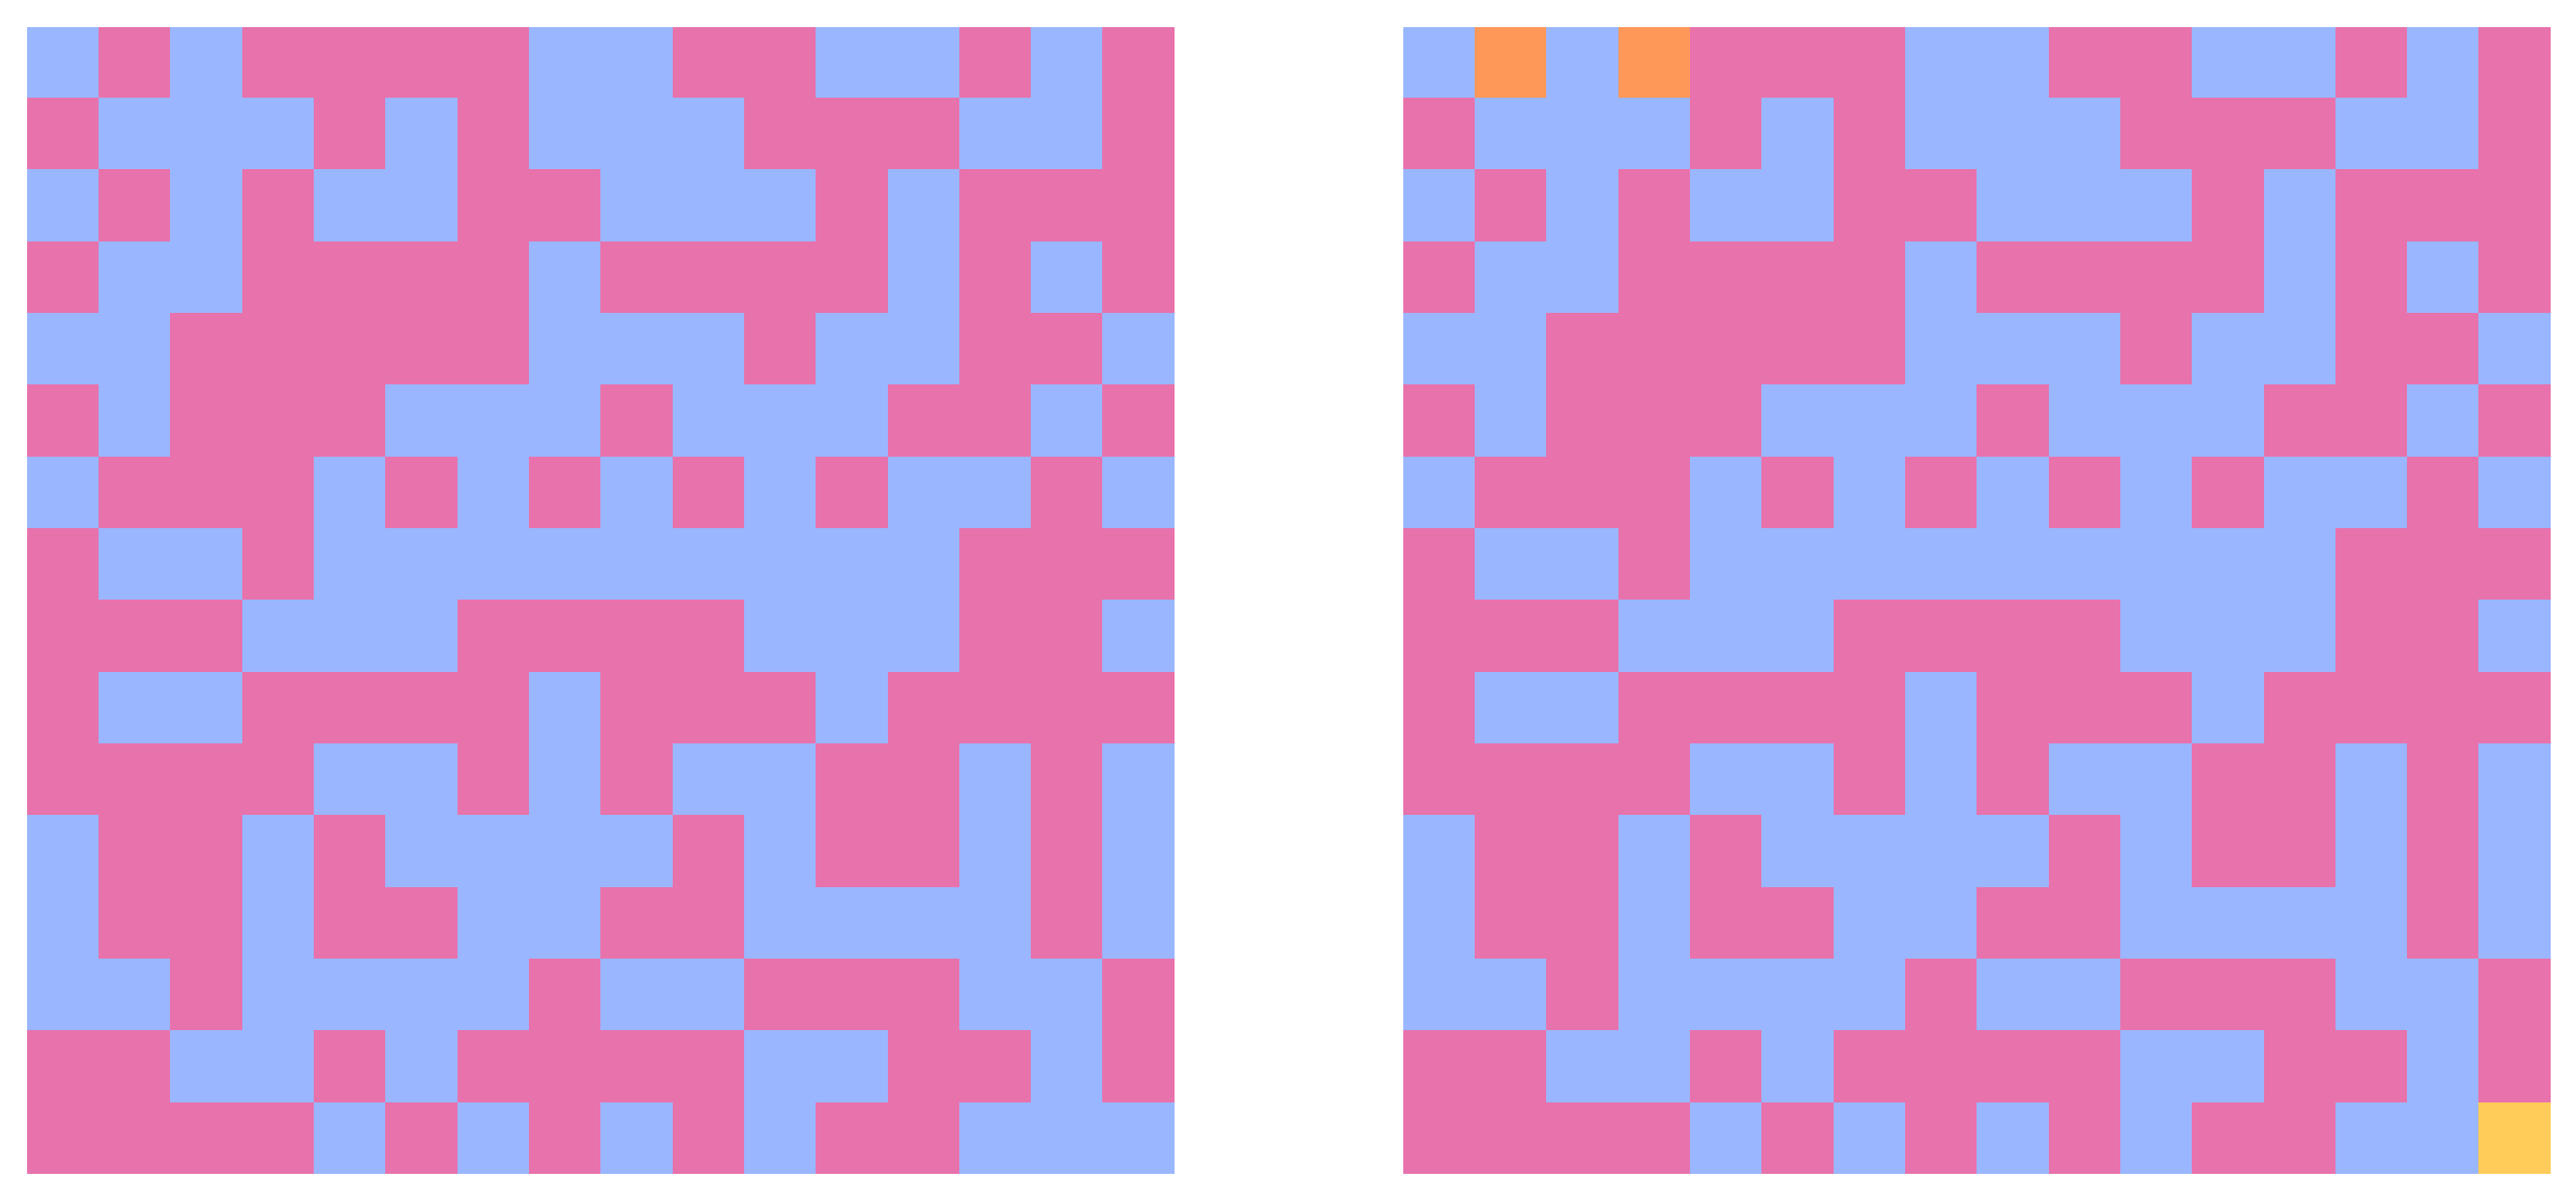

In [27]:
# Generate a matrix to show the compressor
m = np.random.randint(2, size = (16,16))
cmap = ListedColormap(['#DC267F', '#FFB000', '#FE6100', '#648FFF'], 4)
alpha = 0.65

fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (12,12),
    dpi = 300
)

# Display 'uncompressed' example
axes[0].matshow(m, cmap = cmap, alpha = alpha)
axes[0].axis('off')

# Now 'compress' it. Separate 0 and 1 values
zeros = [(i, j) for i, j in zip(*np.where(m < 1))]
ones = [(i, j) for i, j in zip(*np.where(m > 0))]

# Get the first pair of 1 values and the last pair of 0 values to highlight
highlight_1 = zeros[:2]
highlight_0 = ones[-1]

# Change the values to redraw the matrix with highlights
m[tuple(np.transpose(highlight_1))] = 2
m[tuple(np.transpose(ones))] = 3
m[highlight_0] = 1

# Display the 'compressed' example
axes[1].matshow(m, cmap = cmap, alpha = alpha)
axes[1].axis('off');

# Note: I've used a similar technique for the matrices later on in the slides, but 
# used a separate script to generate them, as they a) didn't need to be randomly 
# generated; and b) I got tired of tinkering with image centering with matplotlib.
# The script is misc/draw_ascii_mat.py

### A key difference

+ Compressor: encode into an unused byte
+ Tokenizer: encode by recompiling the original data

Subword tokenization reverses byte-pair encoding. **It decodes by compressing**

Text preprocessing
----------------------

In [14]:
print(
    'iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges ',
    '(corners) of the steel ingot mould. iron cement protects the ingot against the hot, abrasive steel casting ',
    'process. a fire resistant repair cement for fire places, ovens, open fireplaces etc. construction and ',
    'repair of high ways and ... an announcement must be commercial character. goods and services advancement ',
    'through the P.O. Box  system is NOT  ALLOWED. deliveries (spam) and other improper information deleted. ',
    'translator Internet is a Toolbar for MS Internet Explorer. it allows you to translate in real time any web ',
    'page from one'
)

iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges  (corners) of the steel ingot mould. iron cement protects the ingot against the hot, abrasive steel casting  process. a fire resistant repair cement for fire places, ovens, open fireplaces etc. construction and  repair of high ways and ... an announcement must be commercial character. goods and services advancement  through the P.O. Box  system is NOT  ALLOWED. deliveries (spam) and other improper information deleted.  translator Internet is a Toolbar for MS Internet Explorer. it allows you to translate in real time any web  page from one


<div>
    <br>
    <center>
        <img src="data/img/borko_dtm.png" width="35%;" />
    </center>
    <p style="text-align:right;">Borko 1962</p>
    <br>
</div>

### Intermediate forms

+ An "abstract representation that results from a process of formalization into a normalized structure. Intermediate forms **both enable and require calculation** to generate specific outputs like results lists or visual diagrams" (Reider 2020)
+ A "**postorder space** for regularities and resemblances" (McKenzie 2017)
+ Examples
    + Coordinate term indexes
    + Term frequency lists
    + Co-occurrence matrices
    + Feature vectors
+ Between 'raw' text and model outputs: dozens of such forms

**The challenge:** "To a machine, words can only be so many physical things" (Luhn 1958)

In [15]:
to_count = ["count", "counts", "counts", "counts", "counting", "counted"]

print("Word    | Count\n---------------")
for entry, count in Counter(to_count).items():
    print(f"{entry:<12}{count}")

Word    | Count
---------------
count       1
counts      3
counting    1
counted     1


<div>
    <br>
    <center>
        <img src="data/img/borko_dtm.png" width="35%;" style="transform:rotate(90deg);"/>
    </center>
    <p style="text-align:right;">Borko 1962</p>
    <br>
</div>

### A workaround: stemming and lemmatizing

In [16]:
stemmed = [lovins.stem(i) for i in to_count]

print("Word    | Count\n---------------")
for entry, count in Counter(stemmed).items():
    print(f"{entry:<12}{count}")

Word    | Count
---------------
count       6


In [17]:
to_lemmatize = {'corpus': 'n', 'corpora': 'n', 'catch': 'v', 'catching': 'v', 'caught': 'v'}
lemmatized = [lemmatizer.lemmatize(i, pos = t) for i, t in to_lemmatize.items()]

print("Word    | Count\n---------------")
for entry, count in Counter(lemmatized).items():
    print(f"{entry:<12}{count}")

Word    | Count
---------------
corpus      2
catch       3


The "generation of such non-linguistic stems as _cre-_ and _appreci-_ is not a serious problem; if the  purpose of stemming is only to allow related words to match, then the stems yielded by a stemming algorithm need not coincide with those found by a linguist" (Lovins 1968)

In [18]:
to_stem = ['process', 'processing', 'processed', 'matrix', 'matrices', 'textuality']

for word in to_stem:
    stem = lovins.stem(word)
    print(f"{word:<10} => {stem}")

process    => proces
processing => proces
processed  => proces
matrix     => matric
matrices   => matric
textuality => textu


In [19]:
for token in random.choices(bert_vocab, weights = weights, k = 6):
    print(token)

lodge
mbc
##von
humble
searing
rip


In [20]:
problems = ['commission', 'commit', 'universal', 'university']

print("Over-codings\n------------")
for word in problems:
    stem = lovins.stem(word)
    print(f"{word:<10} => {stem}")

Over-codings
------------
commission => commis
commit     => commis
universal  => univers
university => univers


+ Over lemmatizing

+ ...or, **lossy compression**

### Text preprocessing == Data compression

### Text preprocessing == Data compression == Data modeling

Byte-pair encoding redux
------------------------------

In [21]:
to_comp_1 = "Character sequences that occur more than three times will be encoded."
print(f"Original: {to_comp_1}\n\nCompressed: {gage.encode(to_comp_1)[1]}")

Original: Character sequences that occur more than three times will be encoded.

Compressed: b'\x82 thaC\x81racter sequences\x80\x81t occur more\x80\x81n\x80hree\x80imes will be encoded.'


In [22]:
to_comp_2 = ("Algorithms determine our situation. From bubble sort to Google's Page Rank, credit scores, "
             "and predictive policing, the logic of algorithms intervenes at every step in our lives.")
print(f"Original: {to_comp_2}\n\nCompressed: {gage.encode(to_comp_2)[1]}")

Original: Algorithms determine our situation. From bubble sort to Google's Page Rank, credit scores, and predictive policing, the logic of algorithms intervenes at every step in our lives.

Compressed: b"\x8ae s inorit, icteve sAlg\x83\x84hm\x81de\x87rm\x82\x80our\x89\x84uation. From bubbl\x80s\x83t to Google'\x81Pag\x80Rank\x85cred\x84\x89c\x83es\x85and pred\x86tiv\x80pol\x86\x82g\x85th\x80log\x86 of alg\x83\x84hm\x81\x82\x87r\x88ne\x81at e\x88ry\x89\x87p \x82 our li\x88s."


```c
/* compress.c -- Byte Pair Encoding compression */
/* Copyright 1996 Philip Gage */

#include <stdio.h>
#include <stdlib.h>
/* Added by T. Shoemaker */
#include <string.h>

#define MAXSIZE 65535L  /* Input file buffer size */
#define HASHSIZE 8192   /* Hash table size, power of 2 */
#define THRESHOLD   3   /* Increase for speed, min 3 */

void compress (FILE *input, FILE *output)
{
  unsigned char *buffer, *left, *right, *count;
  unsigned char a, b, bestcount=0, pairtable[128][2];
  int i, j, index, bestindex, code=128;
  size_t size;

  /* Dynamically allocate buffers and check for errors */
  buffer = (unsigned char *)malloc(MAXSIZE);
  left = (unsigned char *)malloc(HASHSIZE);
  right = (unsigned char *)malloc(HASHSIZE);
  count = (unsigned char *)malloc(HASHSIZE);
  if (buffer==NULL || left==NULL ||
      right==NULL || count==NULL) {
    printf("Error allocating memory\n");
    exit(1);
  }

  /* Read input file into buffer and check for errors */
  size = fread(buffer,1,MAXSIZE,input);
  if (size == MAXSIZE) {
    printf("File too big\n");
    exit(1);
  }
  for (i=0; i<size; i++)
    if (buffer[i] > 127) {
      ...
    }
```

<div>
    <br>
    <center>
        <img src="data/img/ascii_matrix_highlighted.png" width="60%" />
    </center>
    <br>
</div>

In [23]:
accented = "An áccented string"
message, encoded = gage.encode(accented)
print(
    f"String\n------\n{accented}",
    f"\n\nCompressed to\n-------------\n{encoded}"
    f"\n\nMessage\n-------\n{message}",
)

String
------
An áccented string 

Compressed to
-------------
b''

Message
-------
Break: 00E1
This program works only on text files



```c
for (i = 0; i < size; i++)
    if (buffer[i] > 127) {
        /* Next line added by T. Shoemaker */
        printf("Break: %04X\n", buffer[i]);
        printf("This program works only on text files\n");
        exit(1);
     }
```

<div>
    <br>
    <center>
        <img src="data/img/ascii_matrix.png" width="60%" />
        <p style="text-align:center; margin-top: -25px;">This program works only on text files<p>
    </center>
</div>

What is the _-graphy_ of tokenization?
---------------------------------------------

Typography
--------------

<div style="display:flex;">
    <div style="flex:50%;">
        <center>
            <img src="data/img/hart_divisions.png" width="80%;" style="border:2px solid black;"/>
        </center>
    </div>
    <div style="flex:50%;">
        <center>
            <img src="data/img/lupton_hyphens.png" width="80%;" style="border:2px solid black;"/>
        </center>
        <p style="text-align:right;">Hart 1921 (left); Lupton 2004 (right)</p>
    </div>
</div>

<div style="display:flex;">
    <div style="flex:50%;">
        <p><b>Clark Coolidge, <i>SPACE</i> (1970)</b></p>
        <p>listene<br>secting<br>erences</p>
        <p>miliari<br>contempt<br>opposit</p>
        <p>compani<br>bilitie<br>pontane</p>
        <p>nerousl<br>ercussi<br>dnition</p>
        <p>aluable<br>rievable<br>fluence</p>
        <p>berness<br>ionalis<br>deliber</p>
    </div>
    <div style="flex:50%;">
        <p><b>Lyn Hejinian, <i>Writing is an Aid to Memory</i> (1978)</b></p>
        <p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;guage&nbsp;means&nbsp;general<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;will&nbsp;push&nbsp;straction&nbsp;one&nbsp;day&nbsp;to&nbsp;the&nbsp;left<br>
    carried&nbsp;out&nbsp;on&nbsp;the&nbsp;pebbles<br> &nbsp;drops&nbsp;of&nbsp;water&nbsp;of&nbsp;light&nbsp;off&nbsp;of&nbsp;abstraction&nbsp;in&nbsp;the&nbsp;other</p>
       </div>
</div>

Orthography
---------------

<div>
    <br>
    <center>
        <img src="data/img/bergvall_passengers_passages_1.png" />
        <br>
        <img src="data/img/bergvall_passengers_passages_2.png" />
    </center>
    <p style="text-align:right;">Bergvall 2021</p>
    <br>
</div>

<div>
    <br>
    <center>
        <img src="data/img/lee_ah_ahk_ahk_aht.png" style="border:2px solid black;" />
    </center>
    <p style="text-align:right;">Lee 2015</p>
    <br>
</div>

<div>
    <br>
    <center>
        <img src="data/img/temkin_unicode_compressure.png" width="40%;" style="border:2px solid black;" />
    </center>
    <p style="text-align:right;">Temkin 2014</p>
    <br>
</div>

<div>
    <br>
    <center>
        <img src="data/img/defer_wildcard.png" width="40%;" />
    </center>
</div>

Ideography
-------------

In [26]:
def pair_stats(vocab):
    # Create an empty dictionary to store count data
    pairs = defaultdict(int)
    
    # For every vocabulary word and its associated count:
    for word, freq in vocab.items():
        
        # Split the word into a list of substrings along the whitespace
        # character ("word" => ["w", "o", "r", "d"])
        symbols = word.split()
        
        # Then, for each substring:
        for i in range(len(symbols) - 1):
            
            # Pair it with the next one in the sequence ("w" => "w","o")
            p = symbols[i], symbols[i + 1]
            
            # And either add that pair to the dictionary and give it the word count, 
            # or, if the pair is already in the dictionary, add the new count
            pairs[p] += freq
            
    # Return the count data
    return pairs

### Subword Neural Machine Translation (Sennrich et al. 2016)

```python
"""Use byte pair encoding (BPE) to learn a variable-length encoding of the vocabulary in a text.
Unlike the original BPE, it does not compress the plain text, but can be used to reduce the vocabulary
of a text to a configurable number of symbols, with only a small increase in the number of tokens.
"""
```

```python
parser.add_argument(
    '--symbols', '-s', type=int, default=10000,
    help="Create this many new symbols (each representing a character n-gram) (default: %(default)s)")
```

```python
# don't print end-of-word symbols
if word[-1] == '</w>':
    word = word[:-1]
elif word[-1].endswith('</w>/):
    word[-1] = word[-1][:-4]
```

### BERT on Hugging Face

```rust
impl Symbol {
    /// Merges the current Symbol with the other one.
    /// In order to update prev/next, we consider Self to be the Symbol on the left,
    /// and other to be the next on one the right.
    pub fn merge_with(&mut self, other: &Self, new_c: u32) {
        self.c = new_c;
        self.len += other.len;
        self.next = other.next;
    }
}
```

```python
def get_pairs(word):
    """
    Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs
```

If it were possible to recognize idea building blocks irrespective of the words used to evoke them, these building blocks might be considered the elements of a syntax of notions. Communication could then be carried out by relaying these notions by means of agreed-upon **symbols**. Since these **symbols** would be independent of style and language, they would help to overcome language barriers. A **symbol system** of this kind would be most useful in facilitating the process of information recognition by automatic means (Luhn 1957)